In [10]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import cv2

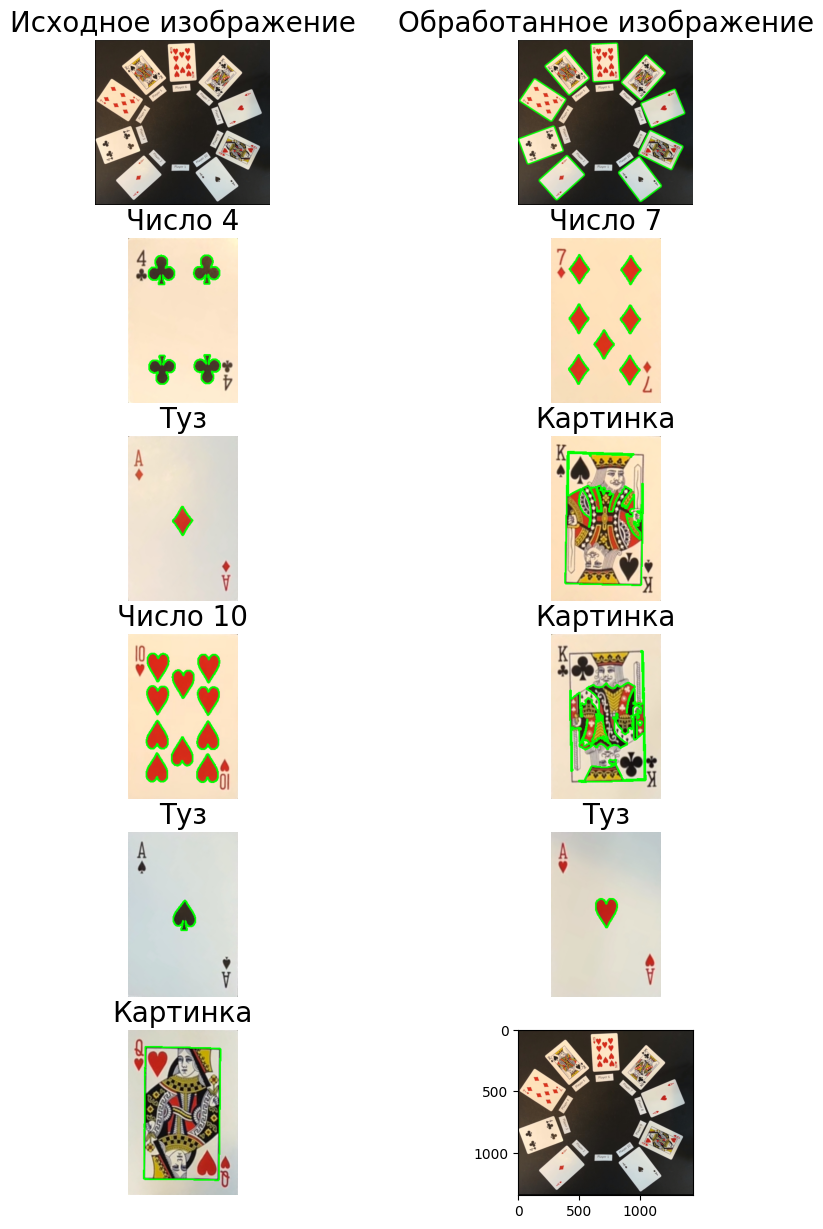

In [123]:
img = imread("image.png")

numcards = 9
font_size = 20
plot_rows = (2 + numcards) // 2 + 1

plt.figure(figsize=(10, 15), facecolor=(0, 0, 0, 0))
plt.subplot(plot_rows, 2, 1).set_title("Исходное изображение", fontsize=font_size)
plt.axis("off")
plt.imshow(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (13, 13), 0)

flag, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:numcards]

contours_img = img.copy()
cv2.drawContours(contours_img, contours, contourIdx=-1, color=(0, 255, 0, 255), thickness=10)
plt.subplot(plot_rows, 2, 2).set_title("Обработанное изображение", fontsize=font_size)
plt.axis("off")
plt.imshow(contours_img)

img_copy = img.copy()
warps = []
for i in range(numcards):
    card = contours[i]
    peri = cv2.arcLength(card, True)
    approx = np.array(cv2.approxPolyDP(card, 0.02 * peri, True), np.float32)
    rect = cv2.minAreaRect(contours[i])
    x, y = [200, 300]
    h = np.array([[0, 0], [x, 0], [x, y], [0, y]], np.float32)
    transform = cv2.getPerspectiveTransform(approx, h)
    warp = cv2.warpPerspective(img, transform, (200, 300))[:, ::-1]
    if rect[1][0] < rect[1][1]:
        warp = np.rot90(warp, axes=(0, 1))
        warp = cv2.resize(warp, (warp.shape[0], warp.shape[1]))
    warps.append(warp)
for (i, warp) in enumerate(warps):
    img_gray = cv2.cvtColor(warp, cv2.COLOR_RGB2GRAY)
    contours_img = warp.copy()

    flag, thresh = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    main_contours = []
    main_area = 0
    for contour in contours:
        if cv2.contourArea(contour) > 0.9 * warp.shape[0] * warp.shape[1]:
            continue
        if main_area == 0:
            main_contours.append(contour)
            main_area = cv2.contourArea(contour)
        else:
            if main_area / 1.1 < cv2.contourArea(contour) < main_area * 1.1:
                main_contours.append(contour)

    if len(main_contours) == 1 and cv2.contourArea(main_contours[0]) > 0.1 * warp.shape[0] * warp.shape[1]:
        title = "Картинка"
    else:
        title = f"Число {len(main_contours)}" if len(main_contours) > 1 else "Туз"

    cv2.drawContours(contours_img, main_contours, contourIdx=-1, color=(0, 255, 0, 255), thickness=2)
    plt.subplot(plot_rows, 2, i + 3).set_title(title, fontsize=font_size)
    plt.axis("off")
    plt.imshow(contours_img)

plt.subplot(plot_rows, 2, 12)
plt.imshow(img_copy)
plt.show()